In [ ]:
# !pip install pmdarima
# !pip install salesforce-merlion
# !pip install arch
# !pip install pymannkendall

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import ADF, KPSS
import pymannkendall as mk
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from merlion.models.utils.autosarima_utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
import copy
import itertools
import warnings

# Suppressing warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the dataset and parsing dates, setting the 'date' column as the index
# Resampling the data to daily frequency and interpolating missing values
orders = pd.read_csv("data-train.csv", parse_dates=["date"], index_col="date").asfreq("D").interpolate()

# Displaying the orders dataframe
orders


,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,11.643281,0.0
2022-06-14,79,11.813969,0.0


In [3]:
# Reading the unseen features dataset and parsing dates, setting the 'date' column as the index
# Resampling the data to daily frequency and interpolating missing values
orders_unseen = pd.read_csv("data-unseen-features.csv", parse_dates=["date"], index_col="date").asfreq("D").interpolate()

# Displaying the orders_unseen dataframe
orders_unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [6]:
# Displaying information about the orders dataframe
orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2020-05-02 to 2022-06-16
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       776 non-null    int64  
 1   temperature  776 non-null    float64
 2   media_spend  776 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [7]:
# Displaying the number of missing values in the orders dataframe
orders.isnull().sum()

orders         0
temperature    0
media_spend    0
dtype: int64

In [8]:
# Displaying the number of missing values in the orders_unseen dataframe
orders_unseen.isnull().sum()

temperature    0
media_spend    0
dtype: int64

In [ ]:
# Displaying unique value counts for each column in the orders dataframe
for col in orders.columns:
    print(f"--- {col} ---")
    print(orders[col].value_counts().sort_index().to_string())
    print("\n")

In [8]:
# # Replacing all values in the 'media_spend' column with 0 for the orders dataframe
# orders['media_spend'] = 0

# # Replacing all values in the 'media_spend' column with 0 for the orders_unseen dataframe
# orders_unseen['media_spend'] = 0

# # Displaying the orders dataframe after replacing values in the 'media_spend' column with 0
# orders

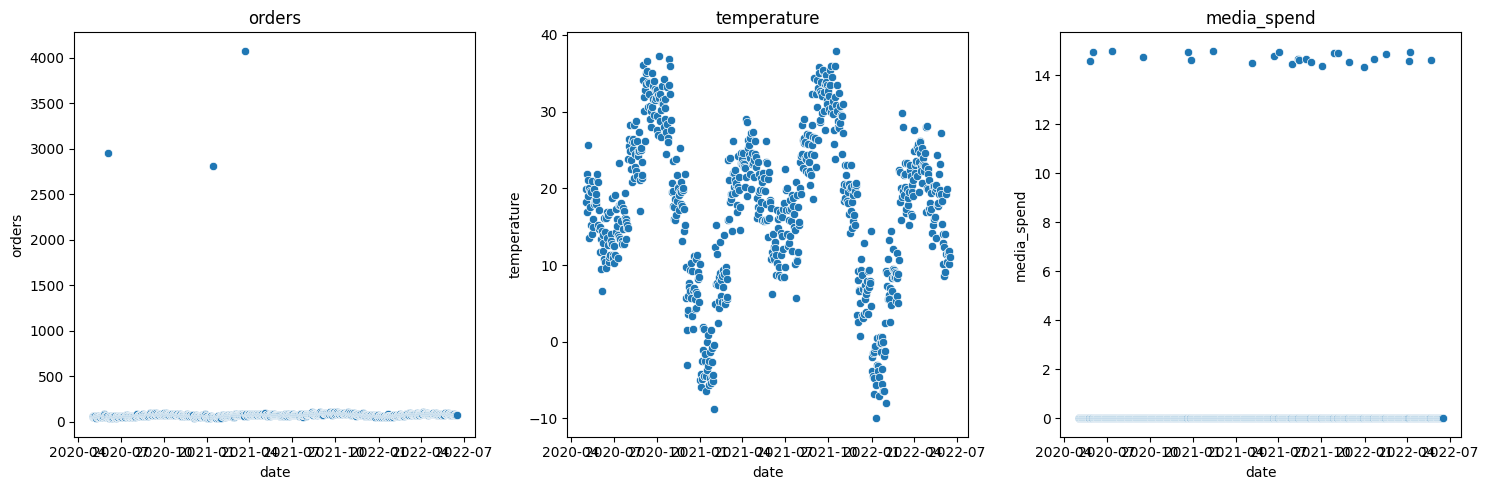

In [10]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.scatterplot(x=orders.index, y=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

In [4]:
# Threshold value set by the user
threshold_value = 1000

# Filter the rows in the 'orders' DataFrame where the 'orders' column value is greater than or equal to the threshold value
orders_outlier = orders[orders['orders'] >= threshold_value]

# Display the filtered DataFrame containing rows with outlier values
orders_outlier

,orders,temperature,media_spend
date,,,
2020-06-03,2952,9.493584,0.0
2021-01-14,2816,-4.468595,0.0
2021-03-22,4080,20.155265,0.0


In [5]:
# Set specific values in the 'orders' column to NaN for the specified dates
orders["orders"].loc[["2020-06-03", "2021-01-14", "2021-03-22"]] = np.NaN

# Display the rows corresponding to the specified dates in the DataFrame
orders.loc[["2020-06-03", "2021-01-14", "2021-03-22"]]

,orders,temperature,media_spend
date,,,
2020-06-03,NaN,9.493584,0.0
2021-01-14,NaN,-4.468595,0.0
2021-03-22,NaN,20.155265,0.0


In [6]:
# Perform linear interpolation to fill missing values in the 'orders' column
orders['orders'] = orders['orders'].interpolate()

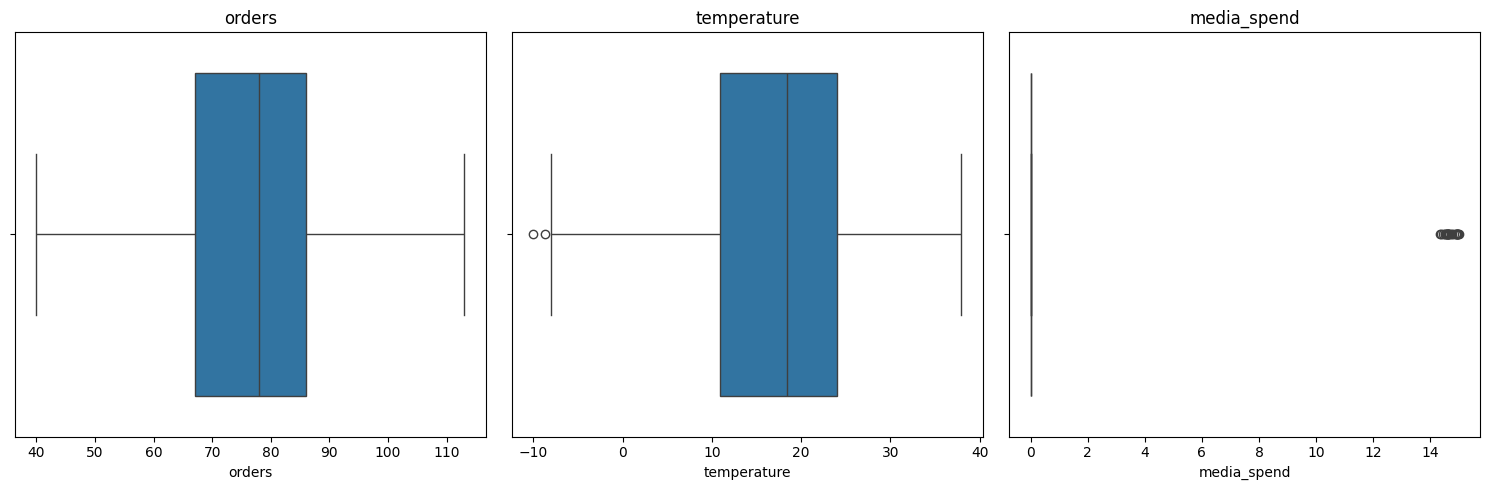

In [14]:
# Create subplots to display boxplots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each boxplot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.boxplot(x=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

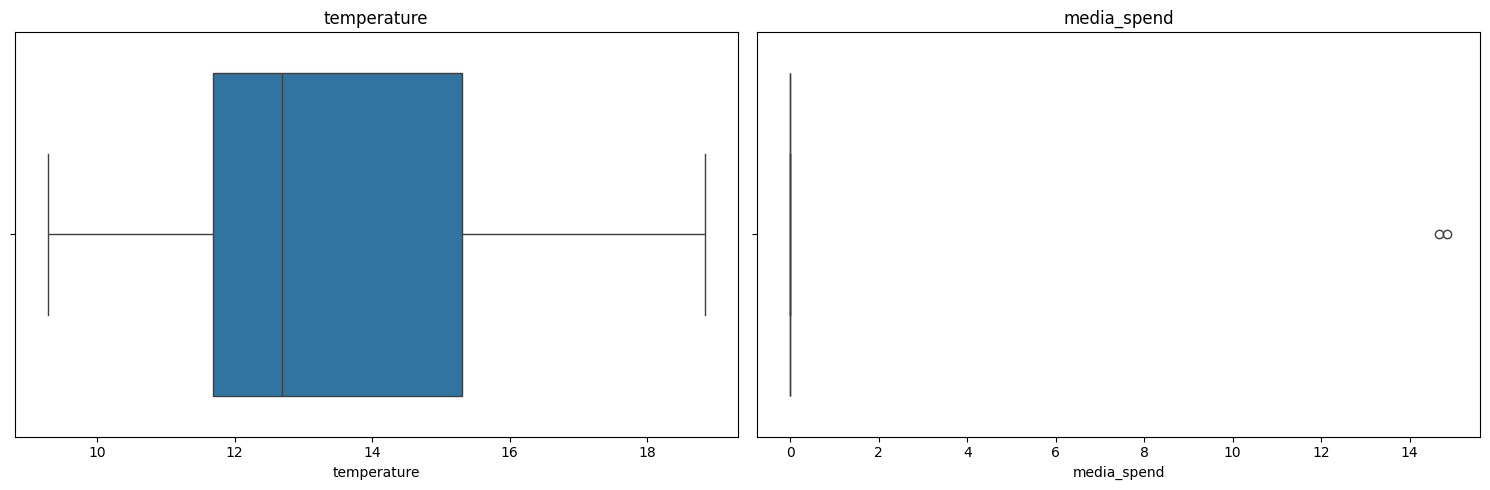

In [15]:
# Create subplots to display boxplots of all columns side by side
fig, axs = plt.subplots(1, len(orders_unseen.columns), figsize=(15, 5))

# Place each boxplot in a separate subplot for each column
for i, col in enumerate(orders_unseen.columns):
    sns.boxplot(x=orders_unseen[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

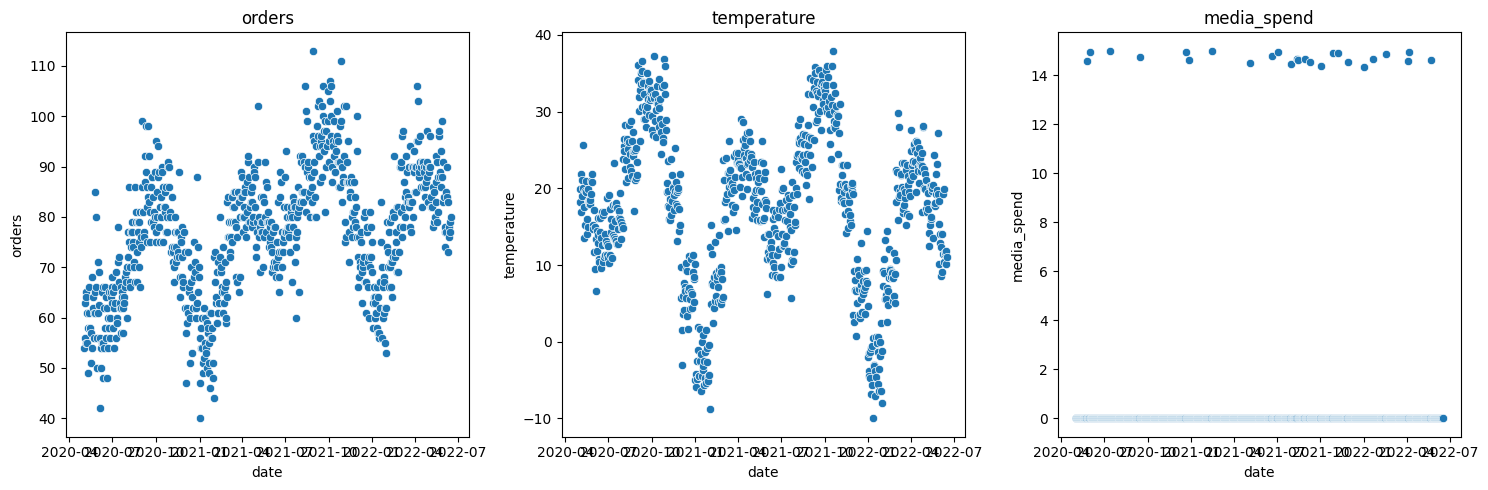

In [16]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders.columns):
    sns.scatterplot(x=orders.index, y=orders[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

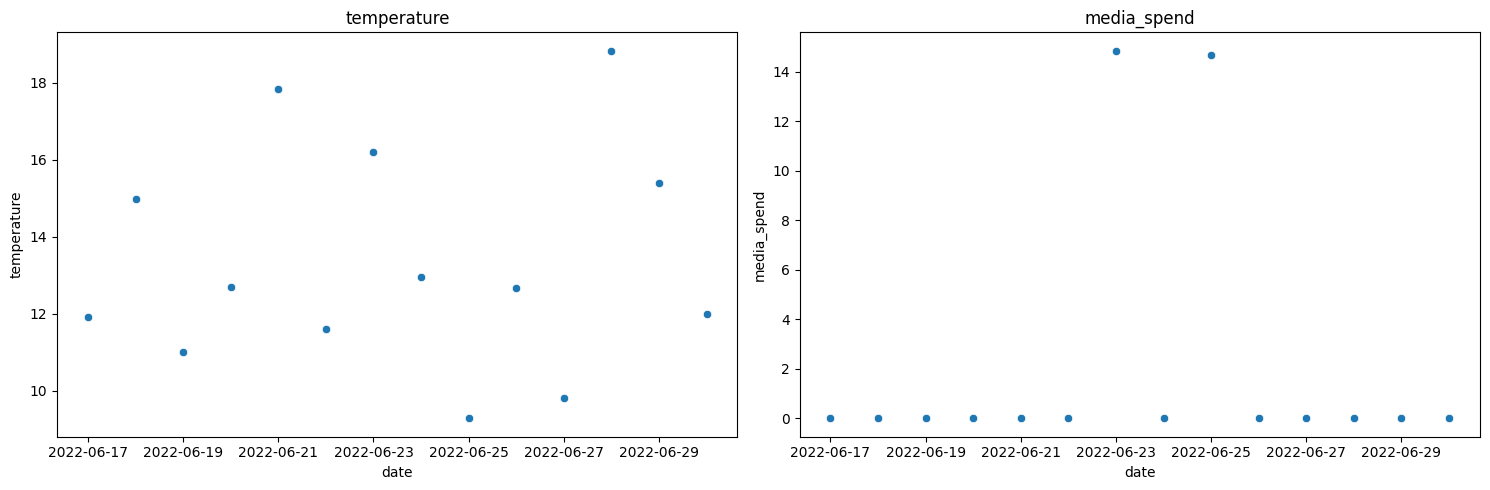

In [17]:
# Create subplots to display scatter plots of all columns side by side
fig, axs = plt.subplots(1, len(orders_unseen.columns), figsize=(15, 5))

# Place each scatter plot in a separate subplot for each column
for i, col in enumerate(orders_unseen.columns):
    sns.scatterplot(x=orders_unseen.index, y=orders_unseen[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()

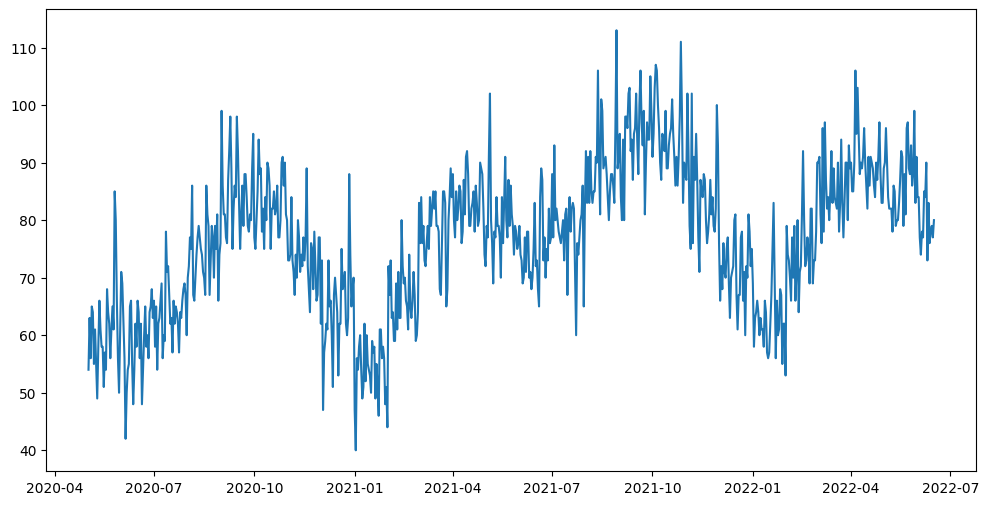

In [18]:
# Create a figure with a specific size to display the plot
plt.figure(figsize=(12,6))

# Plot the 'orders' column from the 'orders' dataframe
plt.plot(orders["orders"])

# Show the plot
plt.show()

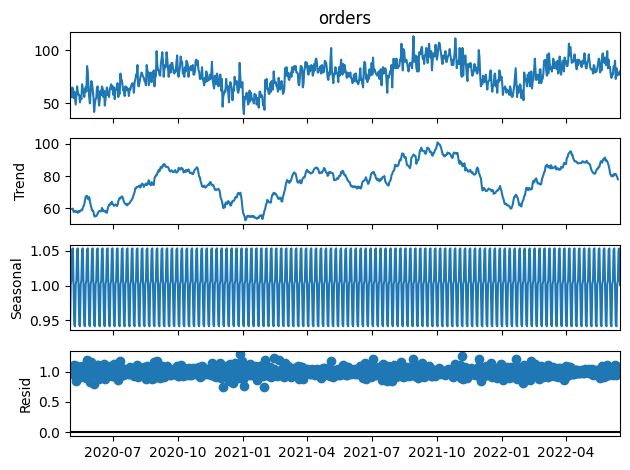

In [19]:
sd = seasonal_decompose(orders["orders"], model="mul", period=7).plot()

In [20]:
# Make a copy of the orders data
data = copy.deepcopy(orders)

# Add a column for the day of the week
data["Day of Week"] = data.index.dayofweek

# Add a column for the months
data["Months"] = data.index.month

# Display the modified data
data

,orders,temperature,media_spend,Day of Week,Months
date,,,,,
2020-05-02,54.0,18.270322,0.0,5,5
2020-05-03,63.0,19.882444,0.0,6,5
2020-05-04,56.0,16.878095,0.0,0,5
2020-05-05,65.0,21.878648,0.0,1,5
2020-05-06,64.0,21.112398,0.0,2,5
...,...,...,...,...,...
2022-06-12,76.0,11.472592,0.0,6,6
2022-06-13,78.0,11.643281,0.0,0,6
2022-06-14,79.0,11.813969,0.0,1,6


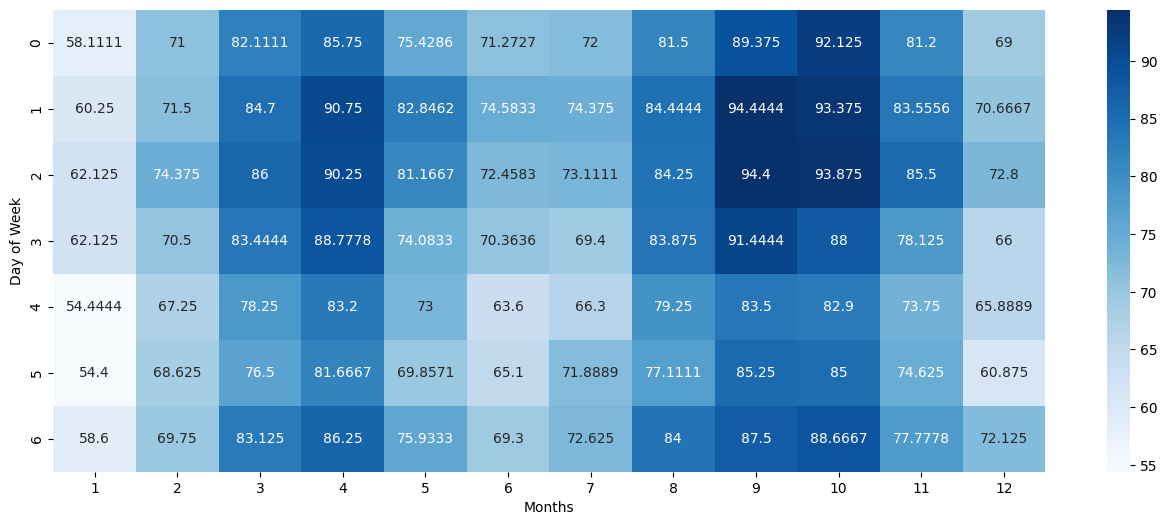

In [21]:
# Create a figure for the heatmap with specific size
plt.figure(figsize=(16, 6))

# Create a pivot table from the data
matrix = pd.pivot_table(data, values="orders", index="Day of Week", columns="Months")

# Define colors for the heatmap
colors = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
sns.heatmap(matrix, annot=True, fmt="g", cmap=colors)

# Show the heatmap
plt.show()

In [7]:
 # Adding a new column for the months by using indexes
orders["Months"] = orders.index.month
orders

,orders,temperature,media_spend,Months
date,,,,
2020-05-02,54.0,18.270322,0.0,5
2020-05-03,63.0,19.882444,0.0,5
2020-05-04,56.0,16.878095,0.0,5
2020-05-05,65.0,21.878648,0.0,5
2020-05-06,64.0,21.112398,0.0,5
...,...,...,...,...
2022-06-12,76.0,11.472592,0.0,6
2022-06-13,78.0,11.643281,0.0,6
2022-06-14,79.0,11.813969,0.0,6


In [8]:
# Converting the "Months" column in the orders DataFrame into dummy variables
dummy_months = pd.get_dummies(orders["Months"], prefix="Month", drop_first=True, dtype=int)

# Adding the created dummy variables to the orders DataFrame
orders = pd.concat([orders, dummy_months], axis=1)

# Printing the orders DataFrame to see the results
orders

,orders,temperature,media_spend,Months,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
date,,,,,,,,,,,,,,,
2020-05-02,54.0,18.270322,0.0,5,0,0,0,1,0,0,0,0,0,0,0
2020-05-03,63.0,19.882444,0.0,5,0,0,0,1,0,0,0,0,0,0,0
2020-05-04,56.0,16.878095,0.0,5,0,0,0,1,0,0,0,0,0,0,0
2020-05-05,65.0,21.878648,0.0,5,0,0,0,1,0,0,0,0,0,0,0
2020-05-06,64.0,21.112398,0.0,5,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,76.0,11.472592,0.0,6,0,0,0,0,1,0,0,0,0,0,0
2022-06-13,78.0,11.643281,0.0,6,0,0,0,0,1,0,0,0,0,0,0
2022-06-14,79.0,11.813969,0.0,6,0,0,0,0,1,0,0,0,0,0,0


In [26]:
# Adding a column for the months in the orders_unseen DataFrame
orders_unseen["Months"] = orders_unseen.index.month

# Converting the "Months" column in the orders_unseen DataFrame into dummy variables
dummy_months_unseen = pd.get_dummies(orders_unseen["Months"], prefix="Month", dtype=int)

# Adding the created dummy variables to the orders_unseen DataFrame
orders_unseen = pd.concat([orders_unseen, dummy_months_unseen], axis=1)

# Assigning initial values of 0 to specific dummy variable columns in the orders_unseen DataFrame
orders_unseen[["Month_2", "Month_3", "Month_4", "Month_5", "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"]] = 0

# Displaying the orders_unseen DataFrame to see the results
orders_unseen

,temperature,media_spend,Months,Month_6,Month_2,Month_3,Month_4,Month_5,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
date,,,,,,,,,,,,,,
2022-06-17,11.923126,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-18,14.986238,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-19,11.003947,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-20,12.699259,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-21,17.852300,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-22,11.601299,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-23,16.207998,14.847883,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-24,12.952067,0.000000,6,1,0,0,0,0,0,0,0,0,0,0
2022-06-25,9.284319,14.664207,6,1,0,0,0,0,0,0,0,0,0,0


In [9]:
# This is a hypotheses test and the two hypotheses are as follows:

# Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
# Ha(Rejected): Sample is not from the normal distributions

# Iterating over each column in the orders DataFrame
for col in orders.columns:
    # Performing Shapiro-Wilk test on the data in the current column
    shapiro_result = shapiro(orders[col])
    
    # Printing the feature name and its corresponding p-value from the Shapiro-Wilk test
    print("Feature:", col, "\nP_value:", shapiro_result[1])

Feature: orders 
P_value: 0.0029592541977763176
Feature: temperature 
P_value: 3.224154099257248e-08
Feature: media_spend 
P_value: 0.0
Feature: Months 
P_value: 6.977414844765986e-16
Feature: Month_2 
P_value: 0.0
Feature: Month_3 
P_value: 0.0
Feature: Month_4 
P_value: 0.0
Feature: Month_5 
P_value: 2.802596928649634e-45
Feature: Month_6 
P_value: 0.0
Feature: Month_7 
P_value: 0.0
Feature: Month_8 
P_value: 0.0
Feature: Month_9 
P_value: 0.0
Feature: Month_10 
P_value: 0.0
Feature: Month_11 
P_value: 0.0
Feature: Month_12 
P_value: 0.0


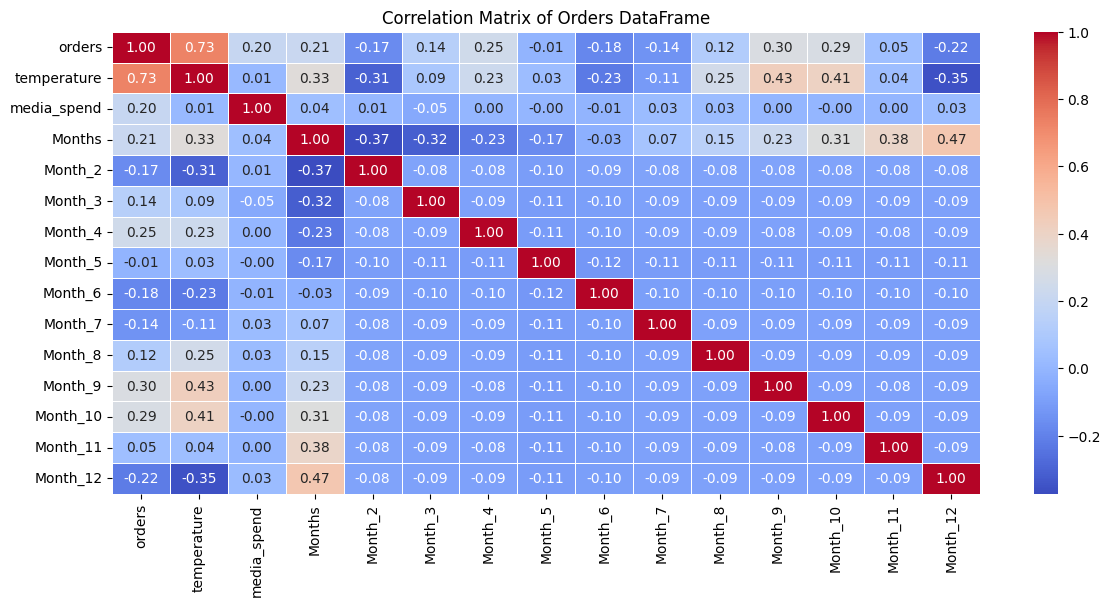

In [21]:
# Calculate the spearman correlation (orders data is not a normal distribution) matrix for the 'orders' dataframe
corr_matrix = orders.corr(method='spearman')

# Plotting the correlation matrix as a heatmap using seaborn
plt.figure(figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Orders DataFrame')
plt.show()

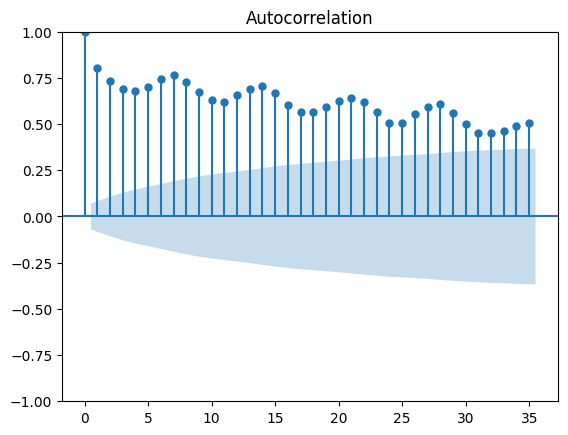

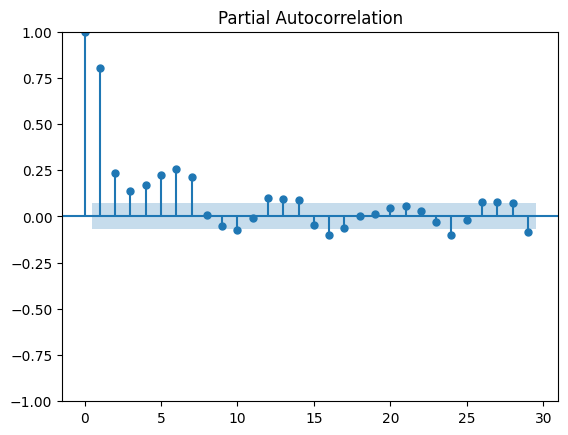

In [36]:
# Plot the autocorrelation function (ACF) for the 'orders' column with lag values up to 35
plot_acf(orders["orders"], lags=35)

# Plot the partial autocorrelation function (PACF) for the 'orders' column
plot_pacf(orders["orders"])

# Show the plots
plt.show()

In [39]:
# Applying the Augmented Dickey-Fuller test to the 'temperature' column in the 'orders' DataFrame with a constant trend
adf = ADF(orders["temperature"], trend="c")

# Printing the Augmented Dickey-Fuller test results
print(adf)

# Printing the summary of regression results from the Augmented Dickey-Fuller test
print(adf.regression.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.436
P-value                         0.132
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     59.35
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           2.97e-52
Time:                        23:16:54   Log-Likelihood:                -2139.5
No. Observations:                 771   AIC:                             4291.
Df Residuals:                     765   BIC:                             4319.

In [40]:
# Calculating the first difference of the 'temperature' column and storing it in a new column 'temperature_diff'
orders["temperature_diff"] = orders["temperature"].diff()

# Filling any missing values in the 'temperature_diff' column with 0
orders["temperature_diff"].fillna(0, inplace=True)

# Displaying the updated 'orders' DataFrame with the 'temperature_diff' column
orders

,orders,temperature,media_spend,Months,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,temperature_diff
date,,,,,,,,,,,,,,,,
2020-05-02,54.0,18.270322,0.0,5,0,0,0,1,0,0,0,0,0,0,0,0.000000
2020-05-03,63.0,19.882444,0.0,5,0,0,0,1,0,0,0,0,0,0,0,1.612122
2020-05-04,56.0,16.878095,0.0,5,0,0,0,1,0,0,0,0,0,0,0,-3.004349
2020-05-05,65.0,21.878648,0.0,5,0,0,0,1,0,0,0,0,0,0,0,5.000553
2020-05-06,64.0,21.112398,0.0,5,0,0,0,1,0,0,0,0,0,0,0,-0.766250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,76.0,11.472592,0.0,6,0,0,0,0,1,0,0,0,0,0,0,-8.405038
2022-06-13,78.0,11.643281,0.0,6,0,0,0,0,1,0,0,0,0,0,0,0.170688
2022-06-14,79.0,11.813969,0.0,6,0,0,0,0,1,0,0,0,0,0,0,0.170688


In [41]:
# Calculating the first difference of the 'temperature' column in the 'orders_unseen' DataFrame and storing it in a new column 'temperature_diff'
orders_unseen["temperature_diff"] = orders_unseen["temperature"].diff()

# Filling any missing values in the 'temperature_diff' column of the 'orders_unseen' DataFrame with 0
orders_unseen["temperature_diff"].fillna(0, inplace=True)

# Displaying the updated 'orders_unseen' DataFrame with the 'temperature_diff' column
orders_unseen

,temperature,media_spend,Months,Month_6,Month_2,Month_3,Month_4,Month_5,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,temperature_diff
date,,,,,,,,,,,,,,,
2022-06-17,11.923126,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,0.000000
2022-06-18,14.986238,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,3.063113
2022-06-19,11.003947,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,-3.982292
2022-06-20,12.699259,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,1.695313
2022-06-21,17.852300,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,5.153040
2022-06-22,11.601299,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,-6.251000
2022-06-23,16.207998,14.847883,6,1,0,0,0,0,0,0,0,0,0,0,4.606699
2022-06-24,12.952067,0.000000,6,1,0,0,0,0,0,0,0,0,0,0,-3.255931
2022-06-25,9.284319,14.664207,6,1,0,0,0,0,0,0,0,0,0,0,-3.667748


In [42]:
# List of exogenous variables to be used in the model
exog_data = ["temperature_diff", "media_spend", "Month_2", "Month_3", "Month_4", "Month_5", "Month_6", "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"]
exog_data

['temperature_diff',
 'media_spend',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12']

In [43]:
# Splitting the orders dataframe into training and testing sets
# Training set: all rows except the last 14 days
data_train = orders.iloc[:-14]

# Testing set: last 14 days
data_test = orders.iloc[-14:]

# Displaying the testing set
data_test

,orders,temperature,media_spend,Months,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,temperature_diff
date,,,,,,,,,,,,,,,,
2022-06-03,77.0,14.021126,0.0,6,0,0,0,0,1,0,0,0,0,0,0,1.166438
2022-06-04,74.0,8.557476,0.0,6,0,0,0,0,1,0,0,0,0,0,0,-5.463650
2022-06-05,78.0,12.326819,0.0,6,0,0,0,0,1,0,0,0,0,0,0,3.769344
2022-06-06,77.0,14.085052,0.0,6,0,0,0,0,1,0,0,0,0,0,0,1.758233
2022-06-07,85.0,9.062854,0.0,6,0,0,0,0,1,0,0,0,0,0,0,-5.022199
2022-06-08,84.0,11.424545,0.0,6,0,0,0,0,1,0,0,0,0,0,0,2.361692
2022-06-09,90.0,19.228510,0.0,6,0,0,0,0,1,0,0,0,0,0,0,7.803964
2022-06-10,73.0,10.436454,0.0,6,0,0,0,0,1,0,0,0,0,0,0,-8.792055
2022-06-11,83.0,19.877631,0.0,6,0,0,0,0,1,0,0,0,0,0,0,9.441176


In [44]:
# Applying the Mann-Kendall original test to detect trend in the 'orders' column
mk.original_test(data_train["orders"])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=13.349935120241595, Tau=0.32305193125497944, s=93666.0, var_s=49226206.0, slope=0.02800658978583196, intercept=67.34349258649094)

In [45]:
# Applying the Augmented Dickey-Fuller (ADF) test to check for stationarity in the 'orders' column
adf = ADF(data_train["orders"])

# Applying the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity in the 'orders' column
kpss = KPSS(data_train["orders"])

# Printing the results of the ADF and KPSS tests
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.342
P-value                         0.159
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.392
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [46]:
# Fitting Ordinary Least Squares (OLS) regression model using statsmodels
model_sm = sm.OLS(endog=data_train["orders"], exog=data_train[exog_data]).fit()

# Printing the summary of the OLS regression model
print(model_sm.summary())

                                 OLS Regression Results                                
Dep. Variable:                 orders   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              960.4
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                        0.00
Time:                        23:19:44   Log-Likelihood:                         -3304.1
No. Observations:                 762   AIC:                                      6634.
Df Residuals:                     749   BIC:                                      6694.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [47]:
# Making predictions using the fitted OLS regression model
pred = model_sm.predict(exog=data_train[exog_data])

# Displaying the predictions
pred

date
2020-05-02    75.346156
2020-05-03    75.910932
2020-05-04    74.293640
2020-05-05    77.098003
2020-05-06    75.077715
                ...    
2022-05-29    78.161542
2022-05-30    71.187542
2022-05-31    76.384078
2022-06-01    64.170948
2022-06-02    67.998109
Freq: D, Length: 762, dtype: float64

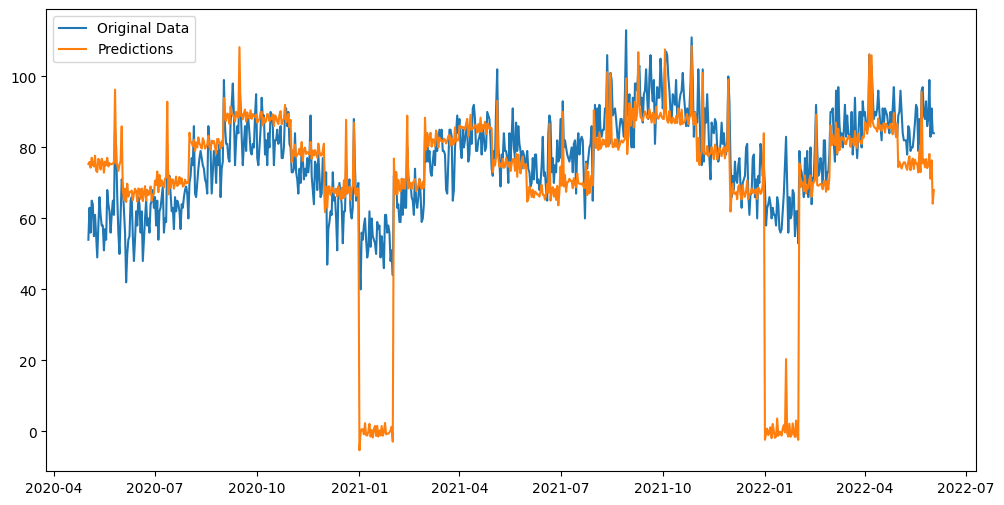

In [48]:
# Creating a figure with a specific size to display the plot
plt.figure(figsize=(12,6))

# Plotting the original 'orders' data
plt.plot(data_train["orders"], label="Original Data")

# Plotting the predictions
plt.plot(pred, label="Predictions")

# Adding legend to the plot
plt.legend()

# Showing the plot
plt.show()

In [49]:
# Calculating the difference of consecutive values in the 'orders' column to obtain the first-order difference
data_orders_diff = data_train["orders"].diff().dropna()

# Displaying the resulting first-order difference data
data_orders_diff

date
2020-05-03     9.0
2020-05-04    -7.0
2020-05-05     9.0
2020-05-06    -1.0
2020-05-07    -9.0
              ... 
2022-05-29    11.0
2022-05-30   -16.0
2022-05-31     8.0
2022-06-01    -7.0
2022-06-02     0.0
Freq: D, Name: orders, Length: 761, dtype: float64

In [50]:
# If test="ch", the Canova-Hansen (1995) test is used (with null hypothesis of deterministic seasonality)
# If test="ocsb", the Osborn-Chui-Smith-Birchenhall (1988) test is used (with null hypothesis that a seasonal unit root exists).

# Performing seasonal differencing using the Chapman-Kolmogorov and OCSB tests
ch = nsdiffs(x=data_train["orders"], m=7, test="ch")
ocsb = nsdiffs(x=data_train["orders"], m=7, test="ocsb")

# Printing the number of seasonal differences suggested by each test
print("ch:", ch)
print("ocsb:", ocsb)

ch: 0
ocsb: 0


In [53]:
# Applying the Augmented Dickey-Fuller (ADF) test to check for stationarity in the differenced data
adf = ADF(data_orders_diff, trend="c")

# Printing the results of the ADF test
print(adf)

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.866
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [54]:
# Print the summary of the regression analysis performed using the Augmented Dickey-Fuller test
print(adf.regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sat, 10 Feb 2024   Prob (F-statistic):          1.38e-208
Time:                        23:20:51   Log-Likelihood:                -2439.0
No. Observations:                 746   AIC:                             4910.
Df Residuals:                     730   BIC:                             4984.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -4.0988      0.462     -8.866      0.0

In [58]:
# Initialize a TimeSeriesSplit object with 5 splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define a function to calculate mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE)
def error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Holt's Linear Trend Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = Holt(train).fit(optimized=True, use_brute=True)
    y_pred = model.forecast(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("Holt Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# Holt-Winters Exponential Smoothing Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit(optimized=True, use_brute=True)
    y_pred = model.forecast(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("Holt-Winters Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# ARIMA Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=False)
    y_pred = model.predict(len(test))
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("ARIMA Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# SARIMA Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    try:
        train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
        model = auto_arima(train, trace=False, seasonal=True, m=7)
        y_pred = model.predict(len(test))
        error = error_metrics(test, y_pred)
        mse.append(error[0])
        rmse.append(error[1])
        mae.append(error[2])
    except ValueError:
        pass
print("SARIMA Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# ARIMAX Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
    train_exog, test_exog = data_train[exog_data].iloc[train_index], data_train[exog_data].iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=False, X=train_exog)
    y_pred = model.predict(len(test), X=test_exog)
    error = error_metrics(test, y_pred)
    mse.append(error[0])
    rmse.append(error[1])
    mae.append(error[2])
print("ARIMAX Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))

# SARIMAX Model
mse = []
rmse = []
mae = []
for train_index, test_index in tscv.split(data_train["orders"]):
    try:
        train, test = data_train["orders"].iloc[train_index], data_train["orders"].iloc[test_index]
        train_exog, test_exog = data_train[exog_data].iloc[train_index], data_train[exog_data].iloc[test_index]
        model = auto_arima(train, trace=False, seasonal=True, m=7, X=train_exog)
        y_pred = model.predict(len(test), X=test_exog)
        error = error_metrics(test, y_pred)
        mse.append(error[0])
        rmse.append(error[1])
        mae.append(error[2])
    except ValueError:
        pass
print("SARIMAX Model - MSE: {} RMSE: {} MAE: {}".format(np.mean(mse), np.mean(rmse), np.mean(mae)))


Holt Model - MSE: 1026.56159853747 RMSE: 28.69637163818576 MAE: 24.482544545791907
Holt-Winters Model - MSE: 464.15546851540347 RMSE: 20.550536766131646 MAE: 17.276225755078578
ARIMA Model - MSE: 372.4591775938487 RMSE: 18.591516052305284 MAE: 15.604679780429217
SARIMA Model - MSE: 432.4792787774244 RMSE: 19.50211076582074 MAE: 16.467417104088202
ARIMAX Model - MSE: 981.8097024467559 RMSE: 21.738127430510257 MAE: 19.049447004984128
SARIMAX Model - MSE: 984.6264285066129 RMSE: 22.49073276563932 MAE: 19.78738971040073


In [63]:
# Automatically selecting SARIMAX model parameters using auto_arima
model = auto_arima(data_train["orders"],
                   seasonal=True, m=7,
                   d=1, D=0,
                   max_p=2, max_q=2,
                   max_P=2, max_Q=2,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   X=data_train[exog_data])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4901.773, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4810.220, Time=3.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4646.344, Time=3.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4899.803, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4707.576, Time=1.32 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4616.007, Time=3.77 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4859.285, Time=3.63 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=4563.075, Time=5.86 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=4589.125, Time=3.19 sec
 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.66 s

In [64]:
# Print model summary by auto_arima
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  762
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -2262.538
Date:                           Sat, 10 Feb 2024   AIC                           4563.075
Time:                                   23:53:16   BIC                           4651.133
Sample:                               05-02-2020   HQIC                          4596.983
                                    - 06-02-2022                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0364      0.010      3.747      0.000       0.017       0.055
temperature_diff     0.49

In [62]:
# Define starting values for the best model
order_aic_bic = []

# Suppress warnings
warnings.filterwarnings("ignore")

# Define parameter ranges
p_range = range(0, 3)
q_range = range(0, 3)
P_range = range(0, 3)
Q_range = range(0, 3)
# d_range = range(0, 3)
# D_range = range(0, 3)
d = 1
D = 0


# Apply grid search
for p, q, P, Q in itertools.product(p_range, q_range, P_range, Q_range):

    try:
        # Fit SARIMAX model with specified parameters
        mod = SARIMAX(data_train['orders'], order=(p, d, q), seasonal_order=(P, D, Q, 7), exog=data_train[exog_data])
        results = mod.fit() 
        
        # Calculate AIC and BIC
        aic = results.aic
        bic = results.bic
        order_aic_bic.append((p, d, q, P, D, Q, aic, bic))
        
    except:
        continue

# Re-enable warnings
warnings.filterwarnings("default")

# Print the best model
order_df = pd.DataFrame(order_aic_bic, columns=["p", "d", "q", "P", "D", "Q", "AIC", "BIC"])
print("Best models sorted by AIC:")
print(order_df.sort_values("AIC"))
print("\nBest models sorted by BIC:")
print(order_df.sort_values("BIC"))

Best models sorted by AIC:
    p  d  q  P  D  Q          AIC          BIC
22  0  1  2  1  0  1  4384.519318  4467.942718
49  1  1  2  1  0  1  4387.923049  4475.981083
43  1  1  1  2  0  1  4390.323727  4478.381761
40  1  1  1  1  0  1  4391.099123  4474.522523
50  1  1  2  1  0  2  4391.216818  4483.909485
.. .. .. .. .. .. ..          ...          ...
2   0  1  0  0  0  2  4857.295836  4931.449970
3   0  1  0  1  0  0  4866.107837  4935.627338
27  1  1  0  0  0  0  4868.408380  4937.927881
1   0  1  0  0  0  1  4875.873115  4945.392616
0   0  1  0  0  0  0  4899.803176  4964.688043

[81 rows x 8 columns]

Best models sorted by BIC:
    p  d  q  P  D  Q          AIC          BIC
22  0  1  2  1  0  1  4384.519318  4467.942718
40  1  1  1  1  0  1  4391.099123  4474.522523
49  1  1  2  1  0  1  4387.923049  4475.981083
43  1  1  1  2  0  1  4390.323727  4478.381761
23  0  1  2  1  0  2  4392.073877  4480.131911
.. .. .. .. .. .. ..          ...          ...
2   0  1  0  0  0  2  4857.29

In [65]:
# Suppressing warnings
warnings.filterwarnings("ignore")

# Creating SARIMAX model for train data set with specified parameters and exogenous variables
sarimax = SARIMAX(data_train["orders"], order=(0, 1, 2), seasonal_order=(1, 0, 1, 7), exog=data_train[exog_data])

# Fitting SARIMAX model
model_sarimax = sarimax.fit()

# Printing the summary of the SARIMAX model
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              orders   No. Observations:                  762
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -2174.260
Date:                             Sat, 10 Feb 2024   AIC                           4384.519
Time:                                     23:54:38   BIC                           4467.943
Sample:                                 05-02-2020   HQIC                          4416.642
                                      - 06-02-2022                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temperature_diff     0.4691      0.029     16.081      0.000       0.412       0.526
media_spe

In [66]:
# If the p-value is less than a chosen significance level (commonly 0.05), it indicates that there is significant autocorrelation present in the residuals.
# If the p-value is greater than the significance level, it suggests that there is no significant autocorrelation in the residuals.

# Perform Ljung-Box test on the residuals of the SARIMAX model
ljung_box = acorr_ljungbox(model_sarimax.resid)

# Print the results of the Ljung-Box test
ljung_box

,lb_stat,lb_pvalue
1,0.296026,0.586385
2,0.389387,0.823087
3,0.510999,0.916469
4,0.602121,0.962828
5,2.552438,0.768578
6,2.973416,0.812176
7,3.599796,0.824545
8,3.819103,0.873065
9,4.322735,0.888917
10,6.617886,0.760959


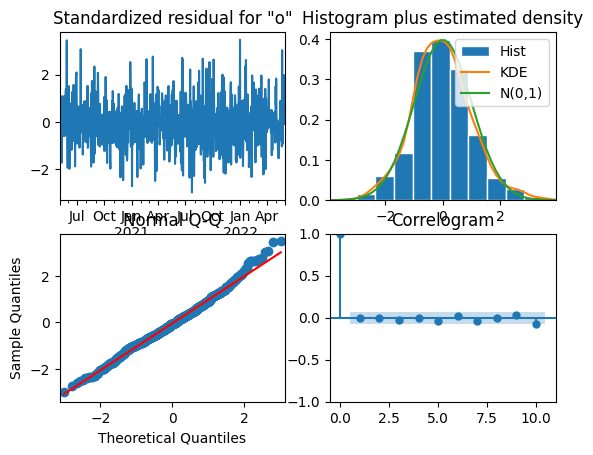

In [67]:
# Visualize diagnostics plots for the SARIMAX model
model_sarimax.plot_diagnostics()

# Show the plots
plt.show()

In [68]:
# Generate train data set predictions using the SARIMAX model with exogenous variable
predictions_train = model_sarimax.predict(exog=data_train[exog_data], start=data_train.index[0], end=data_train.index[len(data_train)-1])

# Create a DataFrame to store observed and predicted values
df_observed = pd.DataFrame()
df_observed["Observed Orders"] = data_train["orders"]
df_observed["SARIMAX Predictions"] = predictions_train

# Display the DataFrame
df_observed

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,19.297756
2020-05-03,63.0,54.755614
2020-05-04,56.0,57.576207
2020-05-05,65.0,59.710683
2020-05-06,64.0,59.378213
...,...,...
2022-05-29,99.0,90.836444
2022-05-30,83.0,82.842026
2022-05-31,91.0,91.390877


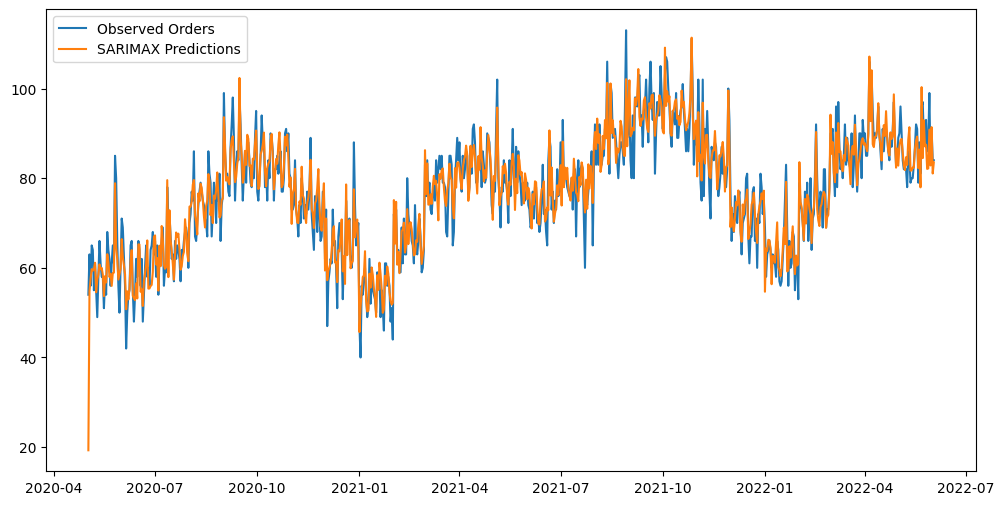

In [69]:
# Plot observed and predicted values from the SARIMAX model
plt.figure(figsize=(12,6))
plt.plot(df_observed)
plt.legend(df_observed.columns)
plt.show()

In [70]:
# Generate test data set forecasted values for future time periods using the SARIMAX model with exogenous variable
forecast_future_test = model_sarimax.forecast(len(data_test), exog=data_test[exog_data])

# Create a DataFrame to store forecasted values for unseen future data
df_unseen_test = pd.DataFrame()
df_unseen_test["SARIMAX Predictions"] = forecast_future_test.values

# Change the index of the second DataFrame
df_unseen_test.index = pd.date_range(start=df_observed.index[-1] + pd.Timedelta(days=1), periods=len(df_unseen_test), name="date")

# Display the DataFrame
df_unseen_test

,SARIMAX Predictions
date,
2022-06-03,79.342680
2022-06-04,75.154405
2022-06-05,83.601581
2022-06-06,82.980935
2022-06-07,82.684747
2022-06-08,86.507466
2022-06-09,85.629437
2022-06-10,74.780460
2022-06-11,82.338324


In [71]:
# Concatenate the two DataFrames
train_test_result_df = pd.concat([df_observed, df_unseen_test], ignore_index=False)

# Show the result
train_test_result_df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,19.297756
2020-05-03,63.0,54.755614
2020-05-04,56.0,57.576207
2020-05-05,65.0,59.710683
2020-05-06,64.0,59.378213
...,...,...
2022-06-12,NaN,78.078366
2022-06-13,NaN,82.423384
2022-06-14,NaN,85.304319


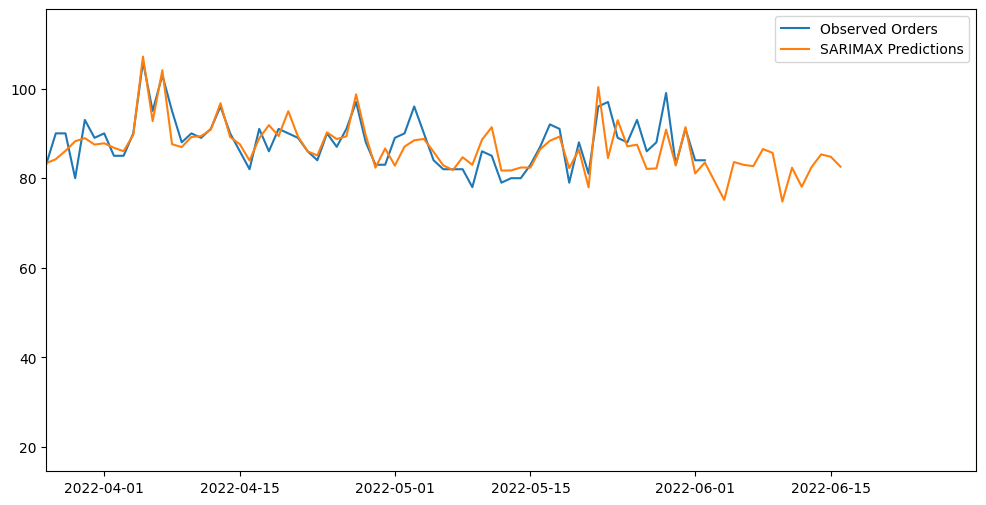

In [72]:
# After creating the plot, select a specific date range using xlim
plt.figure(figsize=(12,6))
plt.plot(train_test_result_df)
plt.legend(train_test_result_df.columns)

# Convert the date range to datetime objects
date_range = pd.to_datetime(['2022-03-26', '2022-06-30'])

# Limit the plot to the specified date range
plt.xlim(date_range)

# Show the plots
plt.show()


In [73]:
# Define a function to calculate error metrics between observed and predicted values
def calculate_error(y, prediction):
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, prediction)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, prediction)
    
    return mse, rmse, mae

In [74]:
# Calculate error metrics between observed and predicted values using the defined function
error_metrics = calculate_error(data_train["orders"], predictions_train)

# Display the error metrics
error_metrics

(19.31773419602627, 4.395194443483277, 3.339113132182465)

In [75]:
# Calculate error metrics between observed and forecasted values using the defined function
error_metrics_test = calculate_error(data_test["orders"], forecast_future_test)

# Display the error metrics
error_metrics_test

(17.082203872728375, 4.133062287545202, 3.562474240252598)

In [76]:
# Suppressing warnings
warnings.filterwarnings("ignore")

# Now, creating SARIMAX model for all data set with specified parameters and exogenous variable
sarimax = SARIMAX(orders["orders"], exog=orders[exog_data], order=(0, 1, 2), seasonal_order=(1, 0, 1, 7))

# Fitting SARIMAX model
model_sarimax = sarimax.fit()

# Printing the summary of the SARIMAX model
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              orders   No. Observations:                  776
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -2214.012
Date:                             Sat, 10 Feb 2024   AIC                           4464.025
Time:                                     23:54:42   BIC                           4547.776
Sample:                                 05-02-2020   HQIC                          4496.246
                                      - 06-16-2022                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temperature_diff     0.4777      0.030     16.119      0.000       0.420       0.536
media_spe

In [77]:
# If the p-value is less than a chosen significance level (commonly 0.05), it indicates that there is significant autocorrelation present in the residuals.
# If the p-value is greater than the significance level, it suggests that there is no significant autocorrelation in the residuals.

# Perform Ljung-Box test on the residuals of the SARIMAX model
ljung_box = acorr_ljungbox(model_sarimax.resid)

# Print the results of the Ljung-Box test
ljung_box

,lb_stat,lb_pvalue
1,0.283213,0.594603
2,0.316982,0.853431
3,0.501792,0.918498
4,0.534284,0.970079
5,2.445490,0.784681
6,2.847417,0.827740
7,3.275841,0.858367
8,3.477973,0.900892
9,4.171565,0.899762
10,6.316237,0.788032


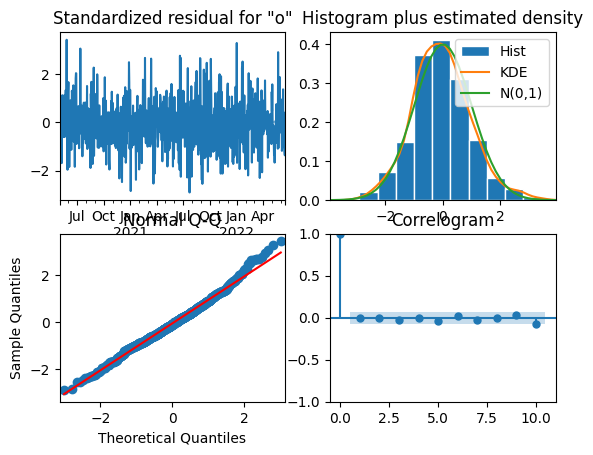

In [78]:
# Visualize diagnostics plots for the SARIMAX model
model_sarimax.plot_diagnostics()

# Show the plots
plt.show()

In [79]:
# Generate predictions using the SARIMAX model with exogenous variable
predictions = model_sarimax.predict(exog=orders[exog_data], start=orders.index[0], end=orders.index[len(orders)-1])

# Create a DataFrame to store observed and predicted values
df = pd.DataFrame()
df["Observed Orders"] = orders["orders"]
df["SARIMAX Predictions"] = predictions

# Display the DataFrame
df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,20.250197
2020-05-03,63.0,54.769520
2020-05-04,56.0,57.572020
2020-05-05,65.0,59.741984
2020-05-06,64.0,59.379484
...,...,...
2022-06-12,76.0,77.355106
2022-06-13,78.0,81.236658
2022-06-14,79.0,83.986579


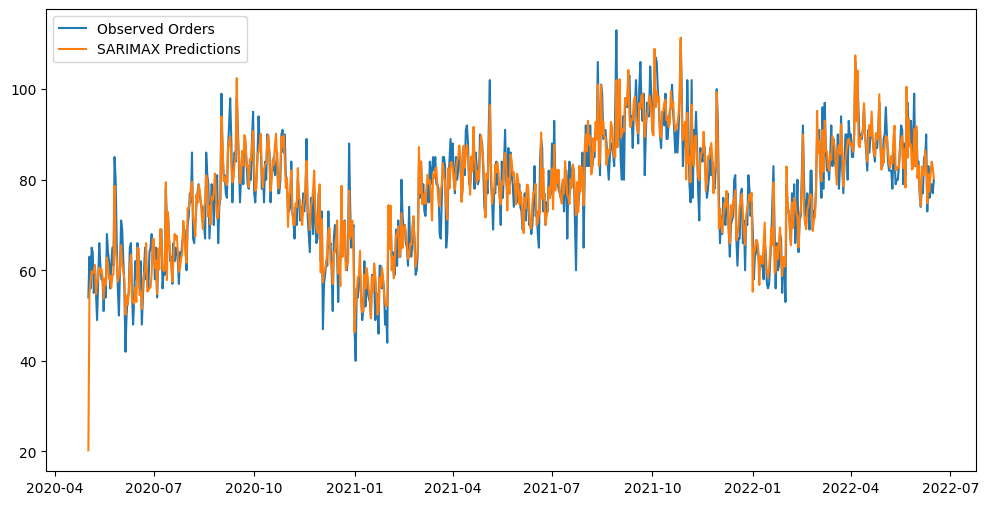

In [80]:
# Plot observed and predicted values from the SARIMAX model
plt.figure(figsize=(12,6))
plt.plot(df)
plt.legend(df.columns)
plt.show()

In [81]:
# Generate forecasted values for future time periods using the SARIMAX model with exogenous variable
forecast_future = model_sarimax.forecast(len(orders_unseen), exog=orders_unseen[exog_data])

# Create a DataFrame to store forecasted values for unseen future data
df_unseen = pd.DataFrame()
df_unseen["SARIMAX Predictions"] = forecast_future.values

# Change the index of the second DataFrame
df_unseen.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(df_unseen), name="date")

# Display the DataFrame
df_unseen

,SARIMAX Predictions
date,
2022-06-17,77.391629
2022-06-18,78.085118
2022-06-19,78.563547
2022-06-20,81.596398
2022-06-21,86.410596
2022-06-22,81.055074
2022-06-23,97.967884
2022-06-24,76.026580
2022-06-25,89.664789


In [82]:
# Concatenate the two DataFrames
result_df = pd.concat([df, df_unseen], ignore_index=False)

# Show the result
result_df

,Observed Orders,SARIMAX Predictions
date,,
2020-05-02,54.0,20.250197
2020-05-03,63.0,54.769520
2020-05-04,56.0,57.572020
2020-05-05,65.0,59.741984
2020-05-06,64.0,59.379484
...,...,...
2022-06-26,NaN,82.224975
2022-06-27,NaN,79.567323
2022-06-28,NaN,88.394270


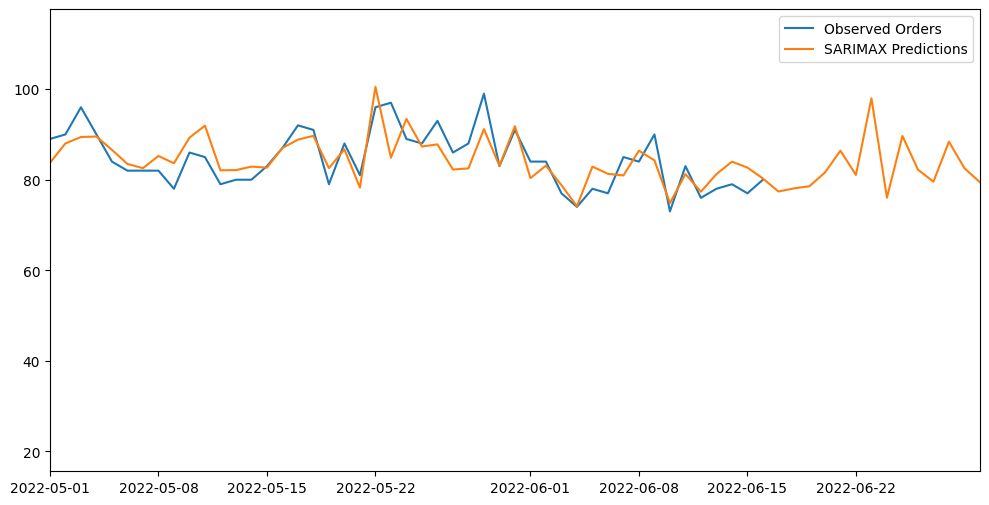

In [83]:
# After creating the plot, select a specific date range using xlim
plt.figure(figsize=(12,6))
plt.plot(result_df)
plt.legend(result_df.columns)

# Convert the date range to datetime objects
date_range = pd.to_datetime(['2022-05-01', '2022-06-30'])

# Limit the plot to the specified date range
plt.xlim(date_range)

# Show the plots
plt.show()


In [84]:
# Calculate error metrics between observed and predicted values using the defined function
error_metrics = calculate_error(orders["orders"], predictions)

# Display the error metrics
error_metrics

(19.202770157176417, 4.38209654813497, 3.3447065783142027)

In [85]:
# Assigning the index values to the 'date' column
df_unseen["date"] = df_unseen.index

# Renaming the column 'SARIMAX Predictions' to 'orders'
df_unseen.rename(columns={"SARIMAX Predictions": "orders"}, inplace=True)

# Resetting the index and dropping the old index column
df_unseen.reset_index(drop=True, inplace=True)

# Defining the new order of columns
new_order = ['date', 'orders']

# Reindexing the DataFrame based on the new column order
df_unseen = df_unseen.reindex(columns=new_order)

# Displaying the updated DataFrame
df_unseen

,date,orders
0,2022-06-17,77.391629
1,2022-06-18,78.085118
2,2022-06-19,78.563547
3,2022-06-20,81.596398
4,2022-06-21,86.410596
5,2022-06-22,81.055074
6,2022-06-23,97.967884
7,2022-06-24,76.026580
8,2022-06-25,89.664789
9,2022-06-26,82.224975


In [86]:
# Save the DataFrame to a CSV file named 'submission.csv' without including the index
df_unseen.to_csv('submission.csv', index=False)

In [87]:
# Read the CSV file 'submission.csv' into a DataFrame
sub1 = pd.read_csv("submission.csv")

# Display the DataFrame
sub1

,date,orders
0,2022-06-17,77.391629
1,2022-06-18,78.085118
2,2022-06-19,78.563547
3,2022-06-20,81.596398
4,2022-06-21,86.410596
5,2022-06-22,81.055074
6,2022-06-23,97.967884
7,2022-06-24,76.026580
8,2022-06-25,89.664789
9,2022-06-26,82.224975
